# Preparation

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pp
import seaborn

In [59]:
%matplotlib inline

# Import data and put into desirable data frame

Extract data from zipfile

In [60]:
import zipfile
zipfile.ZipFile('names.zip').extractall('.')

In [61]:
import os
os.listdir('names')

['NationalReadMe.pdf',
 'yob1880.txt',
 'yob1881.txt',
 'yob1882.txt',
 'yob1883.txt',
 'yob1884.txt',
 'yob1885.txt',
 'yob1886.txt',
 'yob1887.txt',
 'yob1888.txt',
 'yob1889.txt',
 'yob1890.txt',
 'yob1891.txt',
 'yob1892.txt',
 'yob1893.txt',
 'yob1894.txt',
 'yob1895.txt',
 'yob1896.txt',
 'yob1897.txt',
 'yob1898.txt',
 'yob1899.txt',
 'yob1900.txt',
 'yob1901.txt',
 'yob1902.txt',
 'yob1903.txt',
 'yob1904.txt',
 'yob1905.txt',
 'yob1906.txt',
 'yob1907.txt',
 'yob1908.txt',
 'yob1909.txt',
 'yob1910.txt',
 'yob1911.txt',
 'yob1912.txt',
 'yob1913.txt',
 'yob1914.txt',
 'yob1915.txt',
 'yob1916.txt',
 'yob1917.txt',
 'yob1918.txt',
 'yob1919.txt',
 'yob1920.txt',
 'yob1921.txt',
 'yob1922.txt',
 'yob1923.txt',
 'yob1924.txt',
 'yob1925.txt',
 'yob1926.txt',
 'yob1927.txt',
 'yob1928.txt',
 'yob1929.txt',
 'yob1930.txt',
 'yob1931.txt',
 'yob1932.txt',
 'yob1933.txt',
 'yob1934.txt',
 'yob1935.txt',
 'yob1936.txt',
 'yob1937.txt',
 'yob1938.txt',
 'yob1939.txt',
 'yob1940.txt',
 

Take a look at one

In [62]:
open('names/yob2011.txt','r').readlines()[:10]

['Sophia,F,21816\n',
 'Isabella,F,19870\n',
 'Emma,F,18777\n',
 'Olivia,F,17294\n',
 'Ava,F,15480\n',
 'Emily,F,14236\n',
 'Abigail,F,13229\n',
 'Madison,F,12360\n',
 'Mia,F,11512\n',
 'Chloe,F,10970\n']

In [63]:
names2011 = pd.read_csv('names/yob2011.txt', names=['name','sex','number'])
  #Have to add names=[], otherwise it will automatically take the first row as column names
    
names2011.head()

,name,sex,number
0,Sophia,F,21816
1,Isabella,F,19870
2,Emma,F,18777
3,Olivia,F,17294
4,Ava,F,15480


Then we append names from each year into this data frame

In [64]:
names_all = []

for year in range(1880, 2014+1):
    names_all.append(pd.read_csv('names/yob{}.txt'.format(year), names=['name','sex','number']))
    names_all[-1]['year'] = year #Create new column "year" and put value of each year
#names_all contains all data we want, but name, sex, number and year are repeated
#Not one dataframe, but several putting together

#pandas.concat() will concat different data frames into one
allyears = pd.concat(names_all)
allyears.head()

,name,sex,number,year
0,Mary,F,7065,1880
1,Anna,F,2604,1880
2,Emma,F,2003,1880
3,Elizabeth,F,1939,1880
4,Minnie,F,1746,1880


In [65]:
allyears.tail()

,name,sex,number,year
33039,Zykeem,M,5,2014
33040,Zymeer,M,5,2014
33041,Zymiere,M,5,2014
33042,Zyran,M,5,2014
33043,Zyrin,M,5,2014


# Name Popularity

Create new dataframe with multi-indexes: by sex first, then name and year. Also sort the index.

In [66]:
allyears_indexed = allyears.set_index(['sex','name','year']).sort_index()
allyears_indexed.head()

number
sex name      year        
F   Aabha     2011       7
              2012       5
              2014       9
    Aabriella 2008       5
              2014       5

In [67]:
#If we want to look for specific rows, we can use loc() and iloc() to look for the info, for example:
allyears_indexed.loc['F','Mary'].head()

,number
year,
1880,7065
1881,6919
1882,8148
1883,8012
1884,9217


Now we can build a function to plot the popularity of a name across years

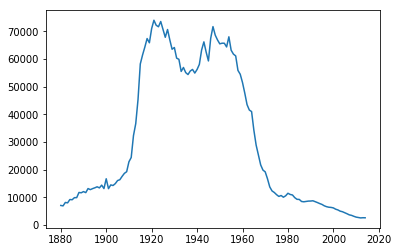

In [68]:
def plotname(sex, name):
    data = allyears_indexed.loc[sex, name]
    pp.plot(data.index, data.values) #data.index is just the year because "year" was used as the index in dataframe above
    
plotname('F','Mary')

Let's try plot some names together

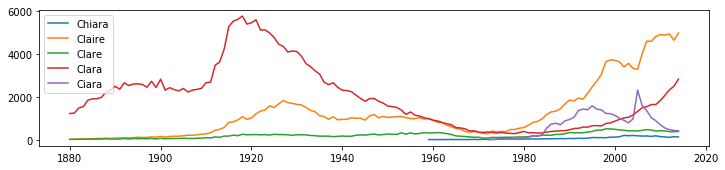

In [69]:
pp.figure(figsize=(12,2.5))

names = ['Chiara','Claire','Clare','Clara','Ciara']
for name in names:
    plotname('F',name)

pp.legend(names)

In [70]:
allyears_indexed.loc['F'].loc[names].head()

number
name   year        
Chiara 1959       9
       1960       5
       1962       8
       1963       8
       1964      12

Unstack the name index, put it to columns (as values) instead

In [71]:
allyears_indexed.loc['F'].loc[names].unstack(level=0).head()
    #level could be either 0 or 1. If level=1 the table rows and columns would be shifted.

number                           
name Chiara Ciara Claire   Clara Clare
year                                  
1880    NaN   NaN   21.0  1226.0  15.0
1881    NaN   NaN   23.0  1242.0  20.0
1882    NaN   NaN   30.0  1490.0  21.0
1883    NaN   NaN   38.0  1548.0  22.0
1884    NaN   NaN   33.0  1852.0  38.0

Fill NaN values with 0, then store into a new data frame called variants

In [72]:
variants = allyears_indexed.loc['F'].loc[names].unstack(level=0).fillna(0)

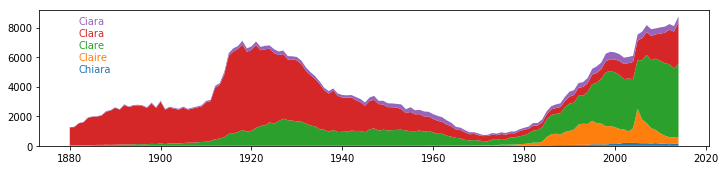

In [73]:
pp.figure(figsize=(12,2.5))
pp.stackplot(variants.index, variants.values.T) #values needs to be transposed here

palette = seaborn.color_palette()

for i,name in enumerate(names):
    pp.text(1882,5000+800*i, name,color = palette[i])